####Likelihood function for $\mathbf{r}_1$:
\begin{eqnarray}
L(s)&=&p(\mathbf{r}_1 |\ s) \\
&=& \prod_{i=0}^N \frac{e^{-g_1 f_i(s)}\ g_1\ f_i(s)^{r_{1i}}}{r_{1i}!} \\
&\propto& \prod_{i=0}^N f_i(s)^{r_{1i}} \\
\end{eqnarray}


####Likelihood function for $\mathbf{r}_1,\ \mathbf{r}_2$:
\begin{eqnarray}
L(s)=p(\mathbf{r}_1 , \mathbf{r}_2\ |\ s) &=& p(\mathbf{r}_1\ |\ s)\ p(\mathbf{r}_2\ |\ s)\\
&\propto& \prod_{i=0}^N f_i(s)^{r_{1i}} \prod _{i=0}^N f_i(s)^{r_{2i}} \\
&\propto& \prod_{i=0}^N f_i(s)^{r_{1i}+r_{2i}}\\
\end{eqnarray}

####Likelihood function for $\mathbf{r}_1+\mathbf{r}_2$:
\begin{eqnarray}
L(s)=p(\mathbf{r}_1 + \mathbf{r}_2\ |\ s)
&=& \prod_{i=0}^N \frac{e^{-f_i(s)(g_1+g_2)}\ (g_1+g_2)\ f_i(s)^{r_{1i}+r_{2i}}}{(r_{1i}+r_{2i})!} \\
&\propto& \prod_{i=0}^N f_i(s)^{r_{1i}+r_{2i}} \\
\end{eqnarray}

<IPython.core.display.Javascript object>


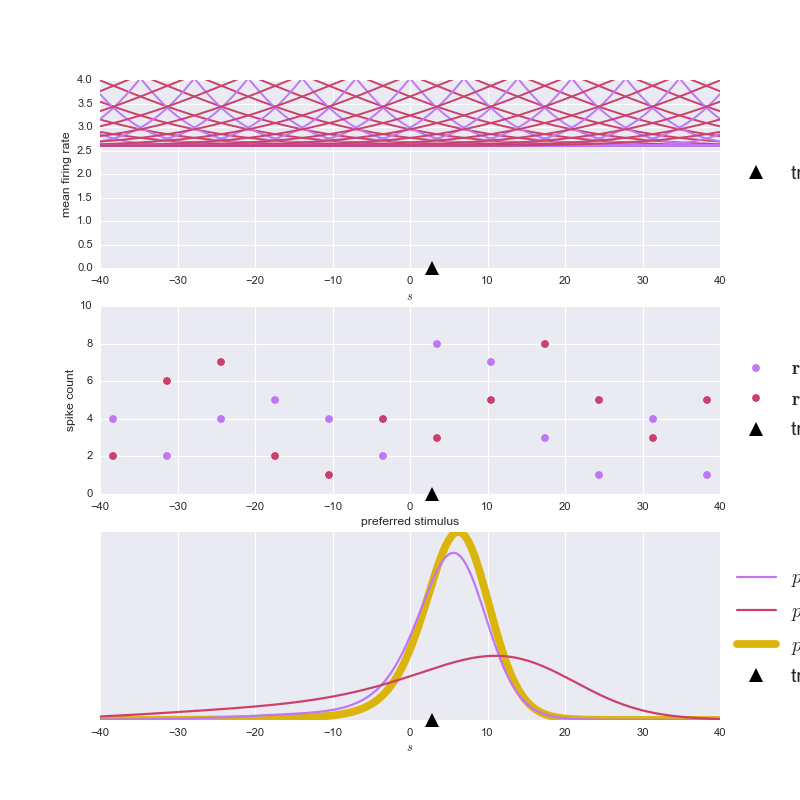

In [2]:
from __future__ import division

import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit, fmin_l_bfgs_b as fminimize
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set_style("darkgrid")
import IPython.html.widgets as widg
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('x-large')
from IPython.display import HTML
%config InlineBackend.figure_format = 'svg'

colors = {'r1':    sns.xkcd_rgb['light purple'],
          'r2':    sns.xkcd_rgb['dark pink'],
          'r1+r2': sns.xkcd_rgb['royal blue'],
          'joint': sns.xkcd_rgb['gold']}

def mean_firing_rate(gain, s, spref, sigma_tc, baseline):
    # tuning curve function
    return baseline + gain * np.exp(-(s-spref)**2/2/sigma_tc**2)

def get_spikes(g, stim, preferred_orientations, sigma_tc, baseline):
    lambdas = mean_firing_rate(g, stim, preferred_orientations, sigma_tc, baseline)
    return np.random.poisson(lambdas)
                
def likelihood(s, r, gain, preferred_orientations, sigma_tc, baseline):
    lambdas = mean_firing_rate(gain, s, preferred_orientations, sigma_tc, baseline)
    return np.prod(np.exp(-lambdas)*lambdas**r/factorial(r))

fig, ax = plt.subplots(3, figsize=(10,10))

def spikes_and_inference(true_stimulus             = 10,
                         number_of_neurons         = 30,
                         population_1_gain         = 2.5,
                         population_2_gain         = 1,
                         population_1_tuning_curve_sigma = 10,
                         population_2_tuning_curve_sigma = 10,
                         tuning_curve_baseline     = 0,
                         show_tuning_curves        = True,
                         population_1              = True,
                         population_2              = False,
                         show_spike_count          = False,
                         show_likelihoods          = False,
                         joint_likelihood          = False,
                         population_1_plus_population_2 = False):
    axes = ax
    max_s = 40
    s_resolution = 250
    preferred_orientations=np.linspace(-max_s*2, max_s*2, number_of_neurons)
    hypothesized_s = np.linspace(-max_s, max_s, s_resolution)

    gains = {'r1':    population_1_gain,
             'r2':    population_2_gain,
             'r1+r2': population_1_gain + population_2_gain}
    sigma_TCs = {'r1':    population_1_tuning_curve_sigma,
                 'r2':    population_2_tuning_curve_sigma,
                 'r1+r2': (population_1_tuning_curve_sigma+population_2_tuning_curve_sigma)/2}
    spikes = {'r1':    get_spikes(gains['r1'], true_stimulus, preferred_orientations, sigma_TCs['r1'], tuning_curve_baseline),
              'r2':    get_spikes(gains['r2'], true_stimulus, preferred_orientations, sigma_TCs['r2'], tuning_curve_baseline)}
    spikes['r1+r2'] = spikes['r1'] + spikes['r2']
    
    active_pops = []
    if population_1: active_pops.append('r1')
    if population_2: active_pops.append('r2')
    if population_1_plus_population_2: active_pops.append('r1+r2')
    
#     nSubplots = show_spike_count + show_tuning_curves + show_likelihoods# + show_sum_of_tuning_curves
    
#     global axes
#     if len(axes) != nSubplots:
#     fig, axes = plt.subplots(nSubplots, figsize=(10,3*nSubplots)) # make number of subplots corresponding to what's been requested
    
    if not isinstance(axes, np.ndarray): axes = [axes] # makes axes into a list even if it's just one subplot

    i=0 # current subplot
    def plot_true_stimulus_and_legend(i):
        axes[i].plot(true_stimulus, 0, 'k^', markersize=12, clip_on=False, label='true stimulus')
        axes[i].legend(loc = 'center left', bbox_to_anchor=(1, 0.5), prop = fontP)
    
    if show_tuning_curves:
        axes[i].cla()
        for neuron in xrange(number_of_neurons):
            if population_1:
                axes[i].plot(hypothesized_s, mean_firing_rate(gains['r1'], hypothesized_s, preferred_orientations[neuron], sigma_TCs['r1'], tuning_curve_baseline), color=colors['r1'])
            if population_2:
                axes[i].plot(hypothesized_s, mean_firing_rate(gains['r2'], hypothesized_s, preferred_orientations[neuron], sigma_TCs['r2'], tuning_curve_baseline), color=colors['r2'])
        axes[i].set_xlabel('$s$')
        axes[i].set_ylabel('mean firing rate')
        axes[i].set_ylim((0,4))
        
        plot_true_stimulus_and_legend(i)

        i += 1

    
    if show_spike_count:
        axes[i].cla()
        
        idx = abs(preferred_orientations) < max_s
        if population_1:
            axes[i].plot(preferred_orientations[idx], spikes['r1'][idx], 'o', color = colors['r1'], clip_on = True,  label='$\mathbf{r}_1$')
        if population_2:
            axes[i].plot(preferred_orientations[idx], spikes['r2'][idx], 'o', color = colors['r2'], clip_on = True, label='$\mathbf{r}_2$')
        if population_1_plus_population_2:
            axes[i].plot(preferred_orientations[idx], spikes['r1+r2'][idx], 'o', color = colors['r1+r2'], clip_on = True, label='$\mathbf{r}_1+\mathbf{r}_2$')
        axes[i].set_xlabel('preferred stimulus')
        axes[i].set_ylabel('spike count')
        axes[i].set_ylim((0,10))
        plot_true_stimulus_and_legend(i)
        i += 1

        
    if show_likelihoods:
        axes[i].cla()
        likelihoods = {}
            
        for population in active_pops:
            likelihoods[population] = np.zeros_like(hypothesized_s)
            
            for idx, ort in enumerate(hypothesized_s):
                likelihoods[population][idx] = likelihood(ort, spikes[population], gains[population], preferred_orientations, sigma_TCs[population], tuning_curve_baseline)

            likelihoods[population] /= np.sum(likelihoods[population]) # normalize

        if population_1:
            axes[i].plot(hypothesized_s, likelihoods['r1'], color = colors['r1'], linewidth=2, label='$p(\mathbf{r}_1|s)$')
        if population_2:
            axes[i].plot(hypothesized_s, likelihoods['r2'], color = colors['r2'], linewidth=2, label='$p(\mathbf{r}_2|s)$')
        if population_1_plus_population_2:
            axes[i].plot(hypothesized_s, likelihoods['r1+r2'], color = colors['r1+r2'], linewidth=2, label='$p(\mathbf{r}_1+\mathbf{r}_2|s)$')
            
#             max_idx = np.argmax(likelihoods['r1+r2'])
#             axes[i].plot(hypothesized_s[max_idx],0, '^', mec=colors['r1+r2'], mew=2.4, mfc='none', markersize=20, clip_on=False, label='$\hat{s}_{MLE}$')
        if joint_likelihood:
            product = likelihoods['r1']*likelihoods['r2']
            product /= np.sum(product)
            axes[i].plot(hypothesized_s, product, color = colors['joint'], linewidth=7, label='$p(\mathbf{r}_1|s)\ p(\mathbf{r}_2|s)$', zorder=1)

        axes[i].set_xlabel('$s$')
        axes[i].legend()
        axes[i].set_yticks([])
        
        plot_true_stimulus_and_legend(i)
        i += 1

    plt.draw()


# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <a href="javascript:code_toggle()">show cell</a>.''')



In [3]:
widg.interact(spikes_and_inference,
              true_stimulus      = (-40, 40, .1),
              number_of_neurons  = (2, 200, 1),
              population_1_gain  = (0, 5, .1),
              population_2_gain  = (0, 5, .1),
              population_1_tuning_curve_sigma = (0.1, 50, .1),
              population_2_tuning_curve_sigma = (0.1, 50, .1),
              tuning_curve_baseline = (0, 20, .1));
